In [1]:
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

### Load the data

In [3]:
path = Path(r"E:\dataset - yuva\1. image\utkface_aligned_cropped\UTKFace")
filenames = list(map(lambda x: x.name,path.glob("*.jpg")))

In [4]:
len(filenames)

23708

### Data Preprocessing

#### 1. Separating the files in the given data

In [5]:
np.random.seed(17)
np.random.shuffle(filenames)

In [6]:
age_labels = []
gender_labels = []
image_path = []

for i in filenames:
    image_path.append(i)
    temp = i.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [7]:
image_path[2]

'36_0_2_20170104203108125.jpg.chip.jpg'

#### 2. Changing the data into dataframe

In [8]:
df = pd.DataFrame()
df['image'] = image_path
df['age'] = age_labels
df['gender'] = gender_labels

In [9]:
df.head()

,image,age,gender
0,23_1_4_20170103224510895.jpg.chip.jpg,23,1
1,24_1_3_20170119171101656.jpg.chip.jpg,24,1
2,36_0_2_20170104203108125.jpg.chip.jpg,36,0
3,29_1_2_20170116172543850.jpg.chip.jpg,29,1
4,41_0_3_20170119171541497.jpg.chip.jpg,41,0


In [10]:
gender_dict = {0:"male",
               1:"Female"}

In [11]:
df = df.astype({'age':'float32',
                'gender':'int32'
               })

In [12]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


C:\Users\Yuva\AppData\Local\Temp\ipykernel_26432\2409177837.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

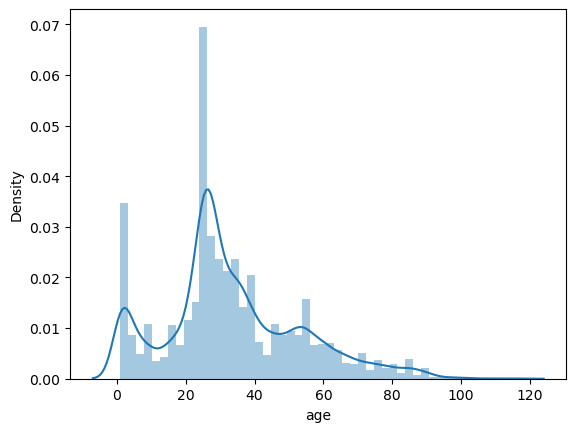

In [13]:
sns.distplot(df.age)

In [14]:
df.image[1]

'24_1_3_20170119171101656.jpg.chip.jpg'

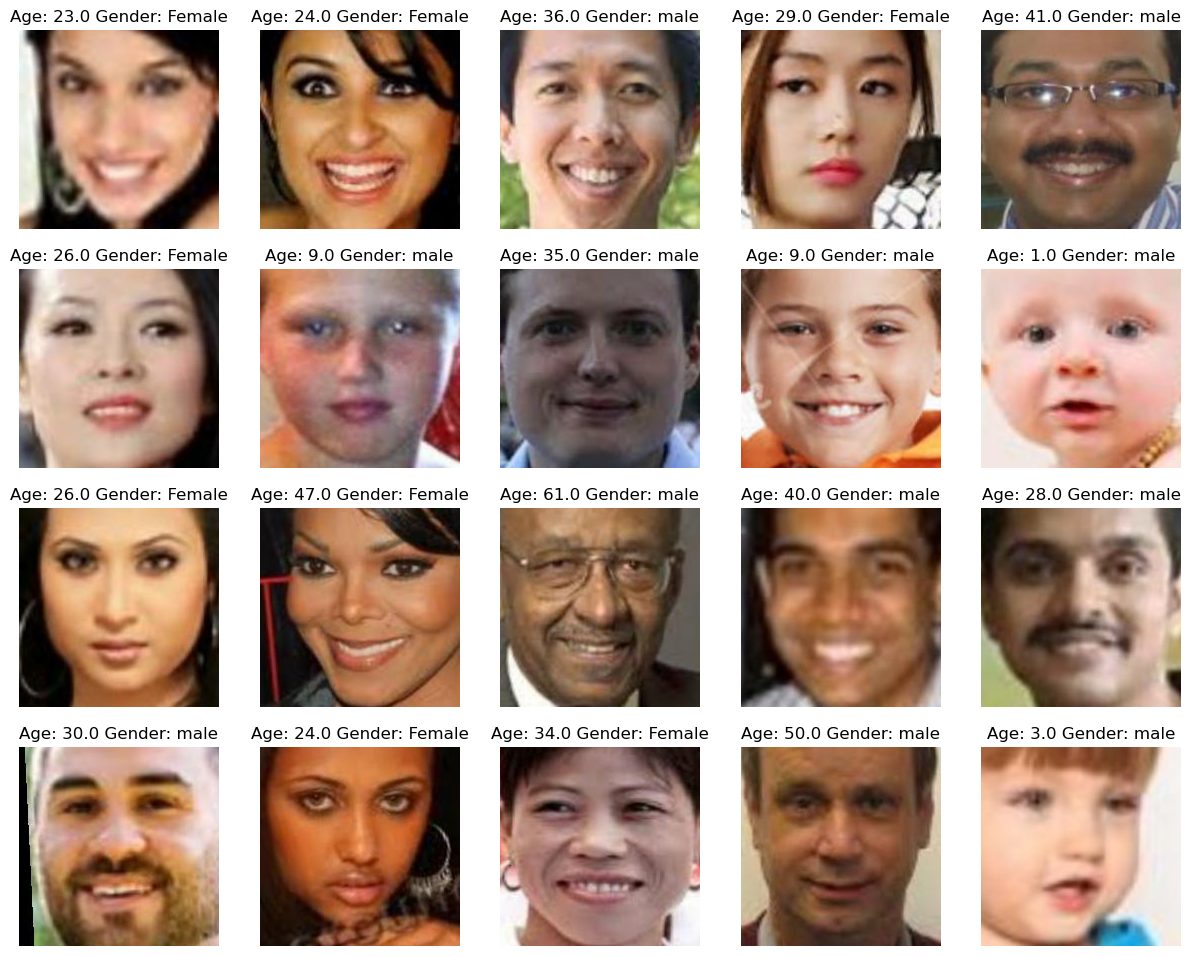

In [15]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("E:/dataset - yuva/1. image/utkface_aligned_cropped/UTKFace/" +file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

#### 3. Splitting the data for training and testing

In [16]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [17]:
train.head()

,image,age,gender
5096,16_0_0_20170110232040957.jpg.chip.jpg,16.0,0
19586,46_0_3_20170119202435756.jpg.chip.jpg,46.0,0
9835,78_0_0_20170111222436497.jpg.chip.jpg,78.0,0
13631,15_0_0_20170105183254311.jpg.chip.jpg,15.0,0
9807,63_1_0_20170120224812560.jpg.chip.jpg,63.0,1


#### 4. Converting features into numpy array

In [19]:
x_train = []

for i in train.image:
    img = load_img("E:/dataset - yuva/1. image/utkface_aligned_cropped/UTKFace/" + i, color_mode = "grayscale")
    img = img.resize((128,128), Image.LANCZOS)
    img = np.array(img)
    x_train.append(img)

In [20]:
x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

In [21]:
x_train.shape

(18966, 128, 128, 1)

#### 5. Normalizing the Data

In [22]:
x_train = x_train/255

In [23]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [24]:
input_size = (128,128,1)

### Model Creation

In [25]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)


X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [26]:
model.compile(loss=['binary_crossentropy','mae'], 
              optimizer='adam', 
              metrics=['accuracy'])


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 126, 126, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 42, 42, 64)           0         ['batch_normalization[0][0

### Training the model

In [28]:
model_history = model.fit(x=x_train, 
                          y=[y_gender, y_age], 
                          batch_size = 10, epochs=10, 
                          validation_split= 0.1)

Epoch 1/10
1707/1707 [==============================] - 458s 268ms/step - loss: 12.1909 - gender_output_loss: 0.4854 - age_output_loss: 11.7056 - gender_output_accuracy: 0.7693 - age_output_accuracy: 0.0215 - val_loss: 9.7845 - val_gender_output_loss: 0.5347 - val_age_output_loss: 9.2498 - val_gender_output_accuracy: 0.7169 - val_age_output_accuracy: 0.0232
Epoch 2/10
1707/1707 [==============================] - 529s 310ms/step - loss: 9.2424 - gender_output_loss: 0.3542 - age_output_loss: 8.8882 - gender_output_accuracy: 0.8378 - age_output_accuracy: 0.0072 - val_loss: 10.1810 - val_gender_output_loss: 0.3357 - val_age_output_loss: 9.8453 - val_gender_output_accuracy: 0.8361 - val_age_output_accuracy: 0.0063
Epoch 3/10
1707/1707 [==============================] - 578s 339ms/step - loss: 8.4240 - gender_output_loss: 0.3112 - age_output_loss: 8.1127 - gender_output_accuracy: 0.8583 - age_output_accuracy: 0.0062 - val_loss: 7.9849 - val_gender_output_loss: 0.3228 - val_age_output_loss: 7

### Predicting the Test image

Original: Gender =  Female  Age =  28.0
1/1 [==============================] - 0s 79ms/step
Prediction: Gender =  Female  Age =  25


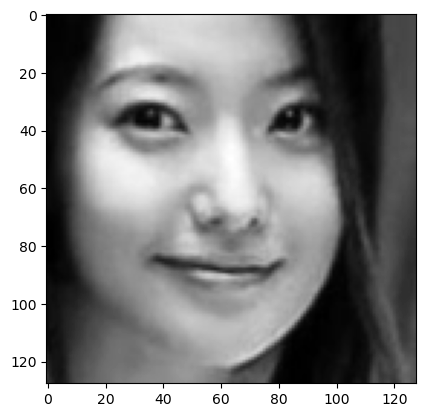

In [30]:
index=20
print("Original: Gender = ", 
      gender_dict[y_gender[index]],
      " Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')